In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(364416, 828)
(364416, 1)
validation
(50712, 828)
(50712, 1)
test
(49296, 828)
(49296, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 45s - loss: 0.1999 - STD: 1.1634e-04 - MAE: 0.4360

 4/37 [==>...........................] - ETA: 1s - loss: 0.0668 - STD: 3.8551e-04 - MAE: 0.1979 

 5/37 [===>..........................] - ETA: 1s - loss: 0.0575 - STD: 3.4293e-04 - MAE: 0.1800

 6/37 [===>..........................] - ETA: 2s - loss: 0.0520 - STD: 3.0316e-04 - MAE: 0.1706

 7/37 [====>.........................] - ETA: 2s - loss: 0.0485 - STD: 2.6926e-04 - MAE: 0.1653

 8/37 [=====>........................] - ETA: 2s - loss: 0.0460 - STD: 2.4102e-04 - MAE: 0.1620

 9/37 [======>.......................] - ETA: 2s - loss: 0.0443 - STD: 2.1761e-04 - MAE: 0.1599

10/37 [=======>......................] - ETA: 2s - loss: 0.0429 - STD: 1.9787e-04 - MAE: 0.1583

11/37 [=======>......................] - ETA: 2s - loss: 0.0418 - STD: 1.8121e-04 - MAE: 0.1572

12/37 [========>.....................] - ETA: 2s - loss: 0.0408 - STD: 1.6695e-04 - MAE: 0.1560

13/37 [=========>....................] - ETA: 2s - loss: 0.0400 - STD: 1.5470e-04 - MAE: 0.1548

14/37 [==========>...................] - ETA: 2s - loss: 0.0391 - STD: 1.4417e-04 - MAE: 0.1536

15/37 [===========>..................] - ETA: 2s - loss: 0.0383 - STD: 1.3506e-04 - MAE: 0.1523

16/37 [===========>..................] - ETA: 2s - loss: 0.0380 - STD: 1.2724e-04 - MAE: 0.1509

20/37 [===============>..............] - ETA: 1s - loss: 0.0348 - STD: 1.0497e-04 - MAE: 0.1439

21/37 [================>.............] - ETA: 1s - loss: 0.0339 - STD: 1.0105e-04 - MAE: 0.1417

22/37 [================>.............] - ETA: 1s - loss: 0.0330 - STD: 9.7612e-05 - MAE: 0.1393

23/37 [=================>............] - ETA: 1s - loss: 0.0321 - STD: 9.4554e-05 - MAE: 0.1368

24/37 [==================>...........] - ETA: 1s - loss: 0.0313 - STD: 9.1743e-05 - MAE: 0.1343

25/37 [===================>..........] - ETA: 1s - loss: 0.0304 - STD: 8.9162e-05 - MAE: 0.1320

26/37 [====================>.........] - ETA: 1s - loss: 0.0296 - STD: 8.6756e-05 - MAE: 0.1299

27/37 [====================>.........] - ETA: 1s - loss: 0.0289 - STD: 8.4572e-05 - MAE: 0.1281

28/37 [=====================>........] - ETA: 0s - loss: 0.0282 - STD: 8.2509e-05 - MAE: 0.1265

29/37 [======================>.......] - ETA: 0s - loss: 0.0276 - STD: 8.0595e-05 - MAE: 0.1253

30/37 [=======================>......] - ETA: 0s - loss: 0.0271 - STD: 7.8721e-05 - MAE: 0.1243

31/37 [========================>.....] - ETA: 0s - loss: 0.0267 - STD: 7.6939e-05 - MAE: 0.1234

32/37 [========================>.....] - ETA: 0s - loss: 0.0262 - STD: 7.5129e-05 - MAE: 0.1226

33/37 [=========================>....] - ETA: 0s - loss: 0.0258 - STD: 7.3399e-05 - MAE: 0.1218

34/37 [==========================>...] - ETA: 0s - loss: 0.0254 - STD: 7.1707e-05 - MAE: 0.1209

35/37 [===========================>..] - ETA: 0s - loss: 0.0249 - STD: 7.0038e-05 - MAE: 0.1199

36/37 [============================>.] - ETA: 0s - loss: 0.0245 - STD: 6.8409e-05 - MAE: 0.1189

37/37 [==============================] - ETA: 0s - loss: 0.0241 - STD: 6.6884e-05 - MAE: 0.1179

37/37 [==============================] - 6s 124ms/step - loss: 0.0241 - STD: 6.6884e-05 - MAE: 0.1179 - val_loss: 0.0085 - val_STD: 8.2215e-06 - val_MAE: 0.0748


Epoch 2/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0099 - STD: 1.1324e-05 - MAE: 0.0777

 2/37 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 1.1756e-05 - MAE: 0.0770

 3/37 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.1683e-05 - MAE: 0.0762

 4/37 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 1.1974e-05 - MAE: 0.0759

 5/37 [===>..........................] - ETA: 3s - loss: 0.0101 - STD: 1.2099e-05 - MAE: 0.0757

 6/37 [===>..........................] - ETA: 3s - loss: 0.0102 - STD: 1.2221e-05 - MAE: 0.0758

 7/37 [====>.........................] - ETA: 3s - loss: 0.0103 - STD: 1.2790e-05 - MAE: 0.0759

 8/37 [=====>........................] - ETA: 3s - loss: 0.0104 - STD: 1.3276e-05 - MAE: 0.0760

 9/37 [======>.......................] - ETA: 2s - loss: 0.0104 - STD: 1.3398e-05 - MAE: 0.0760

10/37 [=======>......................] - ETA: 2s - loss: 0.0104 - STD: 1.3584e-05 - MAE: 0.0759

11/37 [=======>......................] - ETA: 2s - loss: 0.0104 - STD: 1.3558e-05 - MAE: 0.0759

12/37 [========>.....................] - ETA: 2s - loss: 0.0104 - STD: 1.3640e-05 - MAE: 0.0758

13/37 [=========>....................] - ETA: 2s - loss: 0.0104 - STD: 1.3669e-05 - MAE: 0.0759

14/37 [==========>...................] - ETA: 2s - loss: 0.0103 - STD: 1.3679e-05 - MAE: 0.0759

15/37 [===========>..................] - ETA: 2s - loss: 0.0103 - STD: 1.3842e-05 - MAE: 0.0759

16/37 [===========>..................] - ETA: 2s - loss: 0.0102 - STD: 1.3870e-05 - MAE: 0.0761

17/37 [============>.................] - ETA: 2s - loss: 0.0102 - STD: 1.3866e-05 - MAE: 0.0762

18/37 [=============>................] - ETA: 1s - loss: 0.0102 - STD: 1.3963e-05 - MAE: 0.0764

20/37 [===============>..............] - ETA: 1s - loss: 0.0102 - STD: 1.4141e-05 - MAE: 0.0767

21/37 [================>.............] - ETA: 1s - loss: 0.0102 - STD: 1.4219e-05 - MAE: 0.0770

22/37 [================>.............] - ETA: 1s - loss: 0.0102 - STD: 1.4301e-05 - MAE: 0.0771

23/37 [=================>............] - ETA: 1s - loss: 0.0102 - STD: 1.4439e-05 - MAE: 0.0772

24/37 [==================>...........] - ETA: 1s - loss: 0.0102 - STD: 1.4571e-05 - MAE: 0.0774

25/37 [===================>..........] - ETA: 1s - loss: 0.0102 - STD: 1.4712e-05 - MAE: 0.0775

26/37 [====================>.........] - ETA: 1s - loss: 0.0101 - STD: 1.4815e-05 - MAE: 0.0775

27/37 [====================>.........] - ETA: 1s - loss: 0.0101 - STD: 1.4899e-05 - MAE: 0.0775

28/37 [=====================>........] - ETA: 0s - loss: 0.0101 - STD: 1.5053e-05 - MAE: 0.0775

29/37 [======================>.......] - ETA: 0s - loss: 0.0101 - STD: 1.5147e-05 - MAE: 0.0775

30/37 [=======================>......] - ETA: 0s - loss: 0.0101 - STD: 1.5243e-05 - MAE: 0.0775

31/37 [========================>.....] - ETA: 0s - loss: 0.0101 - STD: 1.5354e-05 - MAE: 0.0774

32/37 [========================>.....] - ETA: 0s - loss: 0.0101 - STD: 1.5486e-05 - MAE: 0.0774

33/37 [=========================>....] - ETA: 0s - loss: 0.0101 - STD: 1.5657e-05 - MAE: 0.0773

34/37 [==========================>...] - ETA: 0s - loss: 0.0101 - STD: 1.5829e-05 - MAE: 0.0773

35/37 [===========================>..] - ETA: 0s - loss: 0.0101 - STD: 1.5946e-05 - MAE: 0.0773

36/37 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 1.6047e-05 - MAE: 0.0773

37/37 [==============================] - ETA: 0s - loss: 0.0101 - STD: 1.6135e-05 - MAE: 0.0773

37/37 [==============================] - 4s 108ms/step - loss: 0.0101 - STD: 1.6135e-05 - MAE: 0.0773 - val_loss: 0.0085 - val_STD: 1.3673e-05 - val_MAE: 0.0738


Epoch 3/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0096 - STD: 2.0166e-05 - MAE: 0.0757

 2/37 [>.............................] - ETA: 4s - loss: 0.0097 - STD: 2.0516e-05 - MAE: 0.0766

 3/37 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 2.0789e-05 - MAE: 0.0767

 4/37 [==>...........................] - ETA: 3s - loss: 0.0096 - STD: 2.1192e-05 - MAE: 0.0767

 5/37 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 2.1590e-05 - MAE: 0.0771

 6/37 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 2.1875e-05 - MAE: 0.0773

 7/37 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 2.2071e-05 - MAE: 0.0774

 8/37 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 2.2202e-05 - MAE: 0.0776

 9/37 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 2.2372e-05 - MAE: 0.0777

10/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 2.2581e-05 - MAE: 0.0777

11/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 2.2899e-05 - MAE: 0.0778

12/37 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.3198e-05 - MAE: 0.0778

14/37 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 2.3592e-05 - MAE: 0.0777

15/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 2.3701e-05 - MAE: 0.0777

16/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 2.3797e-05 - MAE: 0.0777

17/37 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 2.3939e-05 - MAE: 0.0777

18/37 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 2.4095e-05 - MAE: 0.0776

19/37 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 2.4290e-05 - MAE: 0.0776

20/37 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 2.4464e-05 - MAE: 0.0775

21/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 2.4662e-05 - MAE: 0.0775

22/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 2.4842e-05 - MAE: 0.0774

23/37 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 2.5031e-05 - MAE: 0.0774

24/37 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 2.5217e-05 - MAE: 0.0774

25/37 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 2.5384e-05 - MAE: 0.0774

26/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 2.5578e-05 - MAE: 0.0775

27/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 2.5779e-05 - MAE: 0.0775

28/37 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 2.6033e-05 - MAE: 0.0775

29/37 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 2.6301e-05 - MAE: 0.0775

30/37 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 2.6557e-05 - MAE: 0.0774

31/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 2.6802e-05 - MAE: 0.0774

32/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 2.7061e-05 - MAE: 0.0774

33/37 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 2.7303e-05 - MAE: 0.0774

34/37 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 2.7538e-05 - MAE: 0.0774

35/37 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 2.7782e-05 - MAE: 0.0774

36/37 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 2.8035e-05 - MAE: 0.0774

37/37 [==============================] - ETA: 0s - loss: 0.0098 - STD: 2.8292e-05 - MAE: 0.0775

37/37 [==============================] - 4s 110ms/step - loss: 0.0098 - STD: 2.8292e-05 - MAE: 0.0775 - val_loss: 0.0085 - val_STD: 2.5562e-05 - val_MAE: 0.0747


Epoch 4/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0097 - STD: 3.8404e-05 - MAE: 0.0769

 2/37 [>.............................] - ETA: 4s - loss: 0.0096 - STD: 3.8517e-05 - MAE: 0.0765

 3/37 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 3.9009e-05 - MAE: 0.0770

 4/37 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.9405e-05 - MAE: 0.0772

 5/37 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 3.9751e-05 - MAE: 0.0772

 6/37 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 4.0141e-05 - MAE: 0.0769

 7/37 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 4.0524e-05 - MAE: 0.0770

 8/37 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 4.0871e-05 - MAE: 0.0771

 9/37 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 4.1206e-05 - MAE: 0.0772

10/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 4.1477e-05 - MAE: 0.0773

11/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 4.1814e-05 - MAE: 0.0773

12/37 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 4.2162e-05 - MAE: 0.0772

13/37 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 4.2532e-05 - MAE: 0.0772

14/37 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 4.2924e-05 - MAE: 0.0773

15/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 4.3256e-05 - MAE: 0.0773

16/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 4.3632e-05 - MAE: 0.0773

17/37 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 4.3984e-05 - MAE: 0.0773

18/37 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 4.4364e-05 - MAE: 0.0773

19/37 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 4.4713e-05 - MAE: 0.0772

20/37 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 4.5112e-05 - MAE: 0.0772

21/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 4.5475e-05 - MAE: 0.0772

22/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 4.5857e-05 - MAE: 0.0772

23/37 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 4.6265e-05 - MAE: 0.0772

24/37 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 4.6658e-05 - MAE: 0.0772

25/37 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 4.7111e-05 - MAE: 0.0772

26/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 4.7557e-05 - MAE: 0.0772

27/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 4.8016e-05 - MAE: 0.0773

28/37 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 4.8483e-05 - MAE: 0.0773

29/37 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 4.8909e-05 - MAE: 0.0773

30/37 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 4.9362e-05 - MAE: 0.0773

31/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 4.9846e-05 - MAE: 0.0773

32/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 5.0307e-05 - MAE: 0.0773

33/37 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 5.0758e-05 - MAE: 0.0773

34/37 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 5.1226e-05 - MAE: 0.0773

35/37 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 5.1715e-05 - MAE: 0.0773

36/37 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 5.2196e-05 - MAE: 0.0773

37/37 [==============================] - ETA: 0s - loss: 0.0098 - STD: 5.2690e-05 - MAE: 0.0773

37/37 [==============================] - 4s 109ms/step - loss: 0.0098 - STD: 5.2690e-05 - MAE: 0.0773 - val_loss: 0.0085 - val_STD: 4.9192e-05 - val_MAE: 0.0747


Epoch 5/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0099 - STD: 7.3094e-05 - MAE: 0.0777

 2/37 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 7.3573e-05 - MAE: 0.0779

 3/37 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 7.4188e-05 - MAE: 0.0781

 4/37 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 7.4770e-05 - MAE: 0.0777

 5/37 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 7.5445e-05 - MAE: 0.0775

 6/37 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 7.6129e-05 - MAE: 0.0775

 7/37 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 7.6792e-05 - MAE: 0.0774

 8/37 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 7.7502e-05 - MAE: 0.0773

 9/37 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 7.8287e-05 - MAE: 0.0774

11/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 7.9897e-05 - MAE: 0.0773

12/37 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 8.0641e-05 - MAE: 0.0773

13/37 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 8.1447e-05 - MAE: 0.0772

14/37 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 8.2264e-05 - MAE: 0.0772

15/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 8.3085e-05 - MAE: 0.0773

16/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 8.3890e-05 - MAE: 0.0773

17/37 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 8.4858e-05 - MAE: 0.0773

18/37 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 8.5731e-05 - MAE: 0.0774

19/37 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 8.6593e-05 - MAE: 0.0773

20/37 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 8.7450e-05 - MAE: 0.0773

21/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 8.8292e-05 - MAE: 0.0773

22/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 8.9153e-05 - MAE: 0.0773

23/37 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 8.9988e-05 - MAE: 0.0773

24/37 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 9.0818e-05 - MAE: 0.0773

25/37 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 9.1723e-05 - MAE: 0.0773

26/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 9.2630e-05 - MAE: 0.0773

27/37 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 9.3624e-05 - MAE: 0.0773

28/37 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 9.4639e-05 - MAE: 0.0773

29/37 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 9.5632e-05 - MAE: 0.0773

30/37 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 9.6681e-05 - MAE: 0.0773

31/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 9.7747e-05 - MAE: 0.0773

32/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 9.8835e-05 - MAE: 0.0773

33/37 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 9.9964e-05 - MAE: 0.0773

34/37 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 1.0118e-04 - MAE: 0.0773

35/37 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 1.0238e-04 - MAE: 0.0773

36/37 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 1.0366e-04 - MAE: 0.0773

37/37 [==============================] - ETA: 0s - loss: 0.0098 - STD: 1.0498e-04 - MAE: 0.0773

37/37 [==============================] - 4s 101ms/step - loss: 0.0098 - STD: 1.0498e-04 - MAE: 0.0773 - val_loss: 0.0085 - val_STD: 1.0573e-04 - val_MAE: 0.0748


Epoch 6/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0098 - STD: 1.5522e-04 - MAE: 0.0774

 2/37 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 1.5632e-04 - MAE: 0.0769

 3/37 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.5854e-04 - MAE: 0.0774

 4/37 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 1.6049e-04 - MAE: 0.0773

 5/37 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 1.6253e-04 - MAE: 0.0771

 6/37 [===>..........................] - ETA: 2s - loss: 0.0098 - STD: 1.6476e-04 - MAE: 0.0772

 7/37 [====>.........................] - ETA: 2s - loss: 0.0098 - STD: 1.6694e-04 - MAE: 0.0771

 8/37 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 1.6914e-04 - MAE: 0.0772

 9/37 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 1.7162e-04 - MAE: 0.0772

10/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 1.7403e-04 - MAE: 0.0773

11/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 1.7644e-04 - MAE: 0.0772

12/37 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 1.7901e-04 - MAE: 0.0772

13/37 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 1.8157e-04 - MAE: 0.0773

14/37 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 1.8404e-04 - MAE: 0.0773

15/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 1.8681e-04 - MAE: 0.0773

17/37 [============>.................] - ETA: 1s - loss: 0.0098 - STD: 1.9270e-04 - MAE: 0.0774

18/37 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 1.9562e-04 - MAE: 0.0774

19/37 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 1.9859e-04 - MAE: 0.0774

20/37 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 2.0159e-04 - MAE: 0.0774

21/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 2.0474e-04 - MAE: 0.0774

22/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 2.0801e-04 - MAE: 0.0774

23/37 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 2.1136e-04 - MAE: 0.0774

24/37 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 2.1482e-04 - MAE: 0.0774

25/37 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 2.1836e-04 - MAE: 0.0774

26/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 2.2206e-04 - MAE: 0.0774

27/37 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 2.2580e-04 - MAE: 0.0774

28/37 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 2.2966e-04 - MAE: 0.0774

29/37 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 2.3353e-04 - MAE: 0.0774

30/37 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 2.3768e-04 - MAE: 0.0774

31/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 2.4188e-04 - MAE: 0.0774

32/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 2.4610e-04 - MAE: 0.0773

33/37 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 2.5050e-04 - MAE: 0.0773

34/37 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 2.5515e-04 - MAE: 0.0773

35/37 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 2.5995e-04 - MAE: 0.0773

36/37 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 2.6482e-04 - MAE: 0.0773

37/37 [==============================] - ETA: 0s - loss: 0.0098 - STD: 2.6993e-04 - MAE: 0.0773

37/37 [==============================] - 4s 96ms/step - loss: 0.0098 - STD: 2.6993e-04 - MAE: 0.0773 - val_loss: 0.0084 - val_STD: 3.2197e-04 - val_MAE: 0.0744


Epoch 7/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0101 - STD: 4.7094e-04 - MAE: 0.0783

 2/37 [>.............................] - ETA: 3s - loss: 0.0101 - STD: 4.8254e-04 - MAE: 0.0782

 3/37 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 4.9141e-04 - MAE: 0.0780

 4/37 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 5.0190e-04 - MAE: 0.0779

 5/37 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 5.1021e-04 - MAE: 0.0778

 6/37 [===>..........................] - ETA: 2s - loss: 0.0099 - STD: 5.2033e-04 - MAE: 0.0778

 7/37 [====>.........................] - ETA: 2s - loss: 0.0099 - STD: 5.3068e-04 - MAE: 0.0778

 8/37 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 5.4241e-04 - MAE: 0.0776

 9/37 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 5.5410e-04 - MAE: 0.0776

10/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 5.6574e-04 - MAE: 0.0775

11/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 5.7717e-04 - MAE: 0.0775

12/37 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 5.8980e-04 - MAE: 0.0774

13/37 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 6.0192e-04 - MAE: 0.0774

14/37 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 6.1492e-04 - MAE: 0.0774

15/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 6.2875e-04 - MAE: 0.0773

16/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 6.4261e-04 - MAE: 0.0773

17/37 [============>.................] - ETA: 1s - loss: 0.0098 - STD: 6.5721e-04 - MAE: 0.0773

18/37 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 6.7220e-04 - MAE: 0.0773

19/37 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 6.8860e-04 - MAE: 0.0773

20/37 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 7.0555e-04 - MAE: 0.0773

21/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 7.2317e-04 - MAE: 0.0773

22/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 7.4190e-04 - MAE: 0.0773

23/37 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 7.6090e-04 - MAE: 0.0773

24/37 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 7.7999e-04 - MAE: 0.0773

25/37 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 8.0040e-04 - MAE: 0.0773

26/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 8.2193e-04 - MAE: 0.0772

27/37 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 8.4336e-04 - MAE: 0.0772

28/37 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 8.6640e-04 - MAE: 0.0772

29/37 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 8.9004e-04 - MAE: 0.0772

30/37 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 9.1483e-04 - MAE: 0.0772

31/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 9.4008e-04 - MAE: 0.0771

32/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 9.6664e-04 - MAE: 0.0771

33/37 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 9.9453e-04 - MAE: 0.0771

34/37 [==========================>...] - ETA: 0s - loss: 0.0097 - STD: 0.0010 - MAE: 0.0770    

35/37 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0011 - MAE: 0.0770

36/37 [============================>.] - ETA: 0s - loss: 0.0097 - STD: 0.0011 - MAE: 0.0770

37/37 [==============================] - 4s 98ms/step - loss: 0.0097 - STD: 0.0011 - MAE: 0.0770 - val_loss: 0.0083 - val_STD: 0.0016 - val_MAE: 0.0737


Epoch 8/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0096 - STD: 0.0024 - MAE: 0.0765

 2/37 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0768

 3/37 [=>............................] - ETA: 3s - loss: 0.0096 - STD: 0.0026 - MAE: 0.0764

 4/37 [==>...........................] - ETA: 3s - loss: 0.0096 - STD: 0.0026 - MAE: 0.0763

 5/37 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.0027 - MAE: 0.0765

 6/37 [===>..........................] - ETA: 2s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0765

 7/37 [====>.........................] - ETA: 2s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0766

 8/37 [=====>........................] - ETA: 2s - loss: 0.0096 - STD: 0.0029 - MAE: 0.0765

 9/37 [======>.......................] - ETA: 2s - loss: 0.0096 - STD: 0.0030 - MAE: 0.0766

11/37 [=======>......................] - ETA: 2s - loss: 0.0096 - STD: 0.0032 - MAE: 0.0764

12/37 [========>.....................] - ETA: 2s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0764

13/37 [=========>....................] - ETA: 2s - loss: 0.0096 - STD: 0.0034 - MAE: 0.0765

14/37 [==========>...................] - ETA: 2s - loss: 0.0096 - STD: 0.0035 - MAE: 0.0764

15/37 [===========>..................] - ETA: 2s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0764

16/37 [===========>..................] - ETA: 1s - loss: 0.0096 - STD: 0.0037 - MAE: 0.0764

17/37 [============>.................] - ETA: 1s - loss: 0.0095 - STD: 0.0038 - MAE: 0.0763

18/37 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 0.0039 - MAE: 0.0763

19/37 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 0.0041 - MAE: 0.0763

20/37 [===============>..............] - ETA: 1s - loss: 0.0095 - STD: 0.0042 - MAE: 0.0762

21/37 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 0.0043 - MAE: 0.0762

22/37 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 0.0044 - MAE: 0.0761

23/37 [=================>............] - ETA: 1s - loss: 0.0095 - STD: 0.0046 - MAE: 0.0761

24/37 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.0047 - MAE: 0.0760

25/37 [===================>..........] - ETA: 1s - loss: 0.0094 - STD: 0.0049 - MAE: 0.0760

26/37 [====================>.........] - ETA: 1s - loss: 0.0094 - STD: 0.0050 - MAE: 0.0759

27/37 [====================>.........] - ETA: 0s - loss: 0.0094 - STD: 0.0052 - MAE: 0.0758

28/37 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0053 - MAE: 0.0757

29/37 [======================>.......] - ETA: 0s - loss: 0.0093 - STD: 0.0055 - MAE: 0.0757

30/37 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 0.0057 - MAE: 0.0757

31/37 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0059 - MAE: 0.0756

32/37 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0061 - MAE: 0.0755

33/37 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0063 - MAE: 0.0755

34/37 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0065 - MAE: 0.0754

35/37 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0067 - MAE: 0.0754

36/37 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0069 - MAE: 0.0753

37/37 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0071 - MAE: 0.0752

37/37 [==============================] - 4s 97ms/step - loss: 0.0092 - STD: 0.0071 - MAE: 0.0752 - val_loss: 0.0074 - val_STD: 0.0101 - val_MAE: 0.0687


Epoch 9/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0089 - STD: 0.0157 - MAE: 0.0737

 2/37 [>.............................] - ETA: 3s - loss: 0.0088 - STD: 0.0160 - MAE: 0.0734

 3/37 [=>............................] - ETA: 3s - loss: 0.0087 - STD: 0.0164 - MAE: 0.0730

 4/37 [==>...........................] - ETA: 3s - loss: 0.0086 - STD: 0.0168 - MAE: 0.0727

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 0.0171 - MAE: 0.0726

 6/37 [===>..........................] - ETA: 2s - loss: 0.0085 - STD: 0.0175 - MAE: 0.0724

 7/37 [====>.........................] - ETA: 2s - loss: 0.0085 - STD: 0.0179 - MAE: 0.0723

 8/37 [=====>........................] - ETA: 2s - loss: 0.0085 - STD: 0.0184 - MAE: 0.0722

 9/37 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.0188 - MAE: 0.0722

10/37 [=======>......................] - ETA: 2s - loss: 0.0084 - STD: 0.0192 - MAE: 0.0720

11/37 [=======>......................] - ETA: 2s - loss: 0.0084 - STD: 0.0196 - MAE: 0.0718

12/37 [========>.....................] - ETA: 2s - loss: 0.0084 - STD: 0.0200 - MAE: 0.0717

14/37 [==========>...................] - ETA: 2s - loss: 0.0083 - STD: 0.0208 - MAE: 0.0715

15/37 [===========>..................] - ETA: 1s - loss: 0.0083 - STD: 0.0212 - MAE: 0.0714

16/37 [===========>..................] - ETA: 1s - loss: 0.0083 - STD: 0.0216 - MAE: 0.0713

17/37 [============>.................] - ETA: 1s - loss: 0.0082 - STD: 0.0221 - MAE: 0.0711

18/37 [=============>................] - ETA: 1s - loss: 0.0082 - STD: 0.0225 - MAE: 0.0710

19/37 [==============>...............] - ETA: 1s - loss: 0.0082 - STD: 0.0229 - MAE: 0.0709

20/37 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.0234 - MAE: 0.0708

21/37 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0238 - MAE: 0.0707

22/37 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0242 - MAE: 0.0706

23/37 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.0246 - MAE: 0.0705

24/37 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.0251 - MAE: 0.0704

25/37 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.0255 - MAE: 0.0703

26/37 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.0259 - MAE: 0.0702

27/37 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.0263 - MAE: 0.0701

28/37 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.0267 - MAE: 0.0701

29/37 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.0271 - MAE: 0.0700

30/37 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0275 - MAE: 0.0699

31/37 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0279 - MAE: 0.0698

32/37 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0283 - MAE: 0.0697

33/37 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0287 - MAE: 0.0696

34/37 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0291 - MAE: 0.0695

35/37 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0295 - MAE: 0.0694

36/37 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0298 - MAE: 0.0693

37/37 [==============================] - ETA: 0s - loss: 0.0078 - STD: 0.0302 - MAE: 0.0692

37/37 [==============================] - 4s 97ms/step - loss: 0.0078 - STD: 0.0302 - MAE: 0.0692 - val_loss: 0.0059 - val_STD: 0.0304 - val_MAE: 0.0595


Epoch 10/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.0437 - MAE: 0.0655

 2/37 [>.............................] - ETA: 3s - loss: 0.0071 - STD: 0.0441 - MAE: 0.0654

 3/37 [=>............................] - ETA: 3s - loss: 0.0070 - STD: 0.0443 - MAE: 0.0648

 4/37 [==>...........................] - ETA: 3s - loss: 0.0070 - STD: 0.0445 - MAE: 0.0648

 5/37 [===>..........................] - ETA: 2s - loss: 0.0069 - STD: 0.0447 - MAE: 0.0645

 6/37 [===>..........................] - ETA: 2s - loss: 0.0069 - STD: 0.0449 - MAE: 0.0644

 7/37 [====>.........................] - ETA: 2s - loss: 0.0069 - STD: 0.0452 - MAE: 0.0644

 8/37 [=====>........................] - ETA: 2s - loss: 0.0069 - STD: 0.0454 - MAE: 0.0644

 9/37 [======>.......................] - ETA: 2s - loss: 0.0069 - STD: 0.0456 - MAE: 0.0644

10/37 [=======>......................] - ETA: 2s - loss: 0.0069 - STD: 0.0459 - MAE: 0.0643

11/37 [=======>......................] - ETA: 2s - loss: 0.0069 - STD: 0.0461 - MAE: 0.0643

12/37 [========>.....................] - ETA: 2s - loss: 0.0068 - STD: 0.0464 - MAE: 0.0643

13/37 [=========>....................] - ETA: 2s - loss: 0.0068 - STD: 0.0465 - MAE: 0.0641

14/37 [==========>...................] - ETA: 2s - loss: 0.0068 - STD: 0.0467 - MAE: 0.0640

16/37 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0471 - MAE: 0.0639

17/37 [============>.................] - ETA: 1s - loss: 0.0068 - STD: 0.0472 - MAE: 0.0638

18/37 [=============>................] - ETA: 1s - loss: 0.0067 - STD: 0.0475 - MAE: 0.0637

19/37 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0476 - MAE: 0.0637

20/37 [===============>..............] - ETA: 1s - loss: 0.0067 - STD: 0.0477 - MAE: 0.0635

21/37 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0479 - MAE: 0.0635

22/37 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0481 - MAE: 0.0634

23/37 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0483 - MAE: 0.0633

24/37 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0484 - MAE: 0.0632

25/37 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0486 - MAE: 0.0631

26/37 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0488 - MAE: 0.0630

27/37 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0489 - MAE: 0.0629

28/37 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0490 - MAE: 0.0628

29/37 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0492 - MAE: 0.0628

30/37 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0493 - MAE: 0.0627

31/37 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0495 - MAE: 0.0626

32/37 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0497 - MAE: 0.0625

33/37 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0498 - MAE: 0.0624

34/37 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0500 - MAE: 0.0623

35/37 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0501 - MAE: 0.0623

36/37 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0503 - MAE: 0.0622

37/37 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0504 - MAE: 0.0621

37/37 [==============================] - 4s 103ms/step - loss: 0.0064 - STD: 0.0504 - MAE: 0.0621 - val_loss: 0.0044 - val_STD: 0.0411 - val_MAE: 0.0515


Epoch 11/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0550 - MAE: 0.0583

 2/37 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0557 - MAE: 0.0583

 3/37 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0562 - MAE: 0.0585

 4/37 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0563 - MAE: 0.0585

 5/37 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0565 - MAE: 0.0585

 6/37 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0585

 7/37 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0585

 8/37 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0585

 9/37 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0584

10/37 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0587

11/37 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0586

12/37 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0585

14/37 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0588

15/37 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0586

16/37 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0587

17/37 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0587

18/37 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0585

19/37 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0585

20/37 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0585 - MAE: 0.0586

21/37 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0585 - MAE: 0.0585

22/37 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0584

23/37 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0585 - MAE: 0.0583

24/37 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0584

25/37 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0583

26/37 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0582

27/37 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0582

28/37 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0582

29/37 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

30/37 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0580

31/37 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0580

32/37 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0580

33/37 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0579

34/37 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0578

35/37 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0578

36/37 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0578

37/37 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0578

37/37 [==============================] - 4s 105ms/step - loss: 0.0057 - STD: 0.0594 - MAE: 0.0578 - val_loss: 0.0042 - val_STD: 0.0453 - val_MAE: 0.0496


Epoch 12/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0597 - MAE: 0.0555

 2/37 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0566

 3/37 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0566

 4/37 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0564

 5/37 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0562

 6/37 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0564

 7/37 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0564

 8/37 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

 9/37 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

10/37 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

11/37 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0560

12/37 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0560

13/37 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

14/37 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0559

15/37 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

16/37 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0559

17/37 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0560

18/37 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0559

19/37 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0559

20/37 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0559

21/37 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0559

22/37 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0558

23/37 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0558

24/37 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0558

25/37 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0558

26/37 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0558

27/37 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0558

28/37 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0558

29/37 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0557

30/37 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0558

31/37 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0557

32/37 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0556

33/37 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0556

34/37 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0632 - MAE: 0.0557

36/37 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0632 - MAE: 0.0556

37/37 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0556

37/37 [==============================] - 4s 106ms/step - loss: 0.0053 - STD: 0.0633 - MAE: 0.0556 - val_loss: 0.0041 - val_STD: 0.0491 - val_MAE: 0.0489


Epoch 13/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0545

 2/37 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0629 - MAE: 0.0541

 3/37 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0639 - MAE: 0.0547

 4/37 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0643 - MAE: 0.0549

 5/37 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0641 - MAE: 0.0547

 6/37 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0642 - MAE: 0.0546

 7/37 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0548

 8/37 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0546

 9/37 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0545

10/37 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0646 - MAE: 0.0546

11/37 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0648 - MAE: 0.0546

12/37 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0649 - MAE: 0.0545

13/37 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0650 - MAE: 0.0545

14/37 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0651 - MAE: 0.0544

15/37 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0652 - MAE: 0.0543

16/37 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0543

17/37 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0542

18/37 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0654 - MAE: 0.0542

19/37 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0655 - MAE: 0.0542

20/37 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0654 - MAE: 0.0541

21/37 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0655 - MAE: 0.0542

22/37 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0542

23/37 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0542

24/37 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0655 - MAE: 0.0542

25/37 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0541

26/37 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0541

27/37 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0542

28/37 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0542

29/37 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0541

30/37 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0657 - MAE: 0.0541

31/37 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0657 - MAE: 0.0541

32/37 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0657 - MAE: 0.0541

33/37 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0657 - MAE: 0.0540

35/37 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0658 - MAE: 0.0540

36/37 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0658 - MAE: 0.0540

37/37 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0658 - MAE: 0.0540

37/37 [==============================] - 4s 107ms/step - loss: 0.0050 - STD: 0.0658 - MAE: 0.0540 - val_loss: 0.0043 - val_STD: 0.0532 - val_MAE: 0.0492


Epoch 14/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0536

 2/37 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0657 - MAE: 0.0530

 3/37 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0536

 4/37 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0534

 5/37 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0667 - MAE: 0.0534

 6/37 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0533

 7/37 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0667 - MAE: 0.0531

 8/37 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0533

 9/37 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0532

10/37 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0666 - MAE: 0.0532

11/37 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0533

12/37 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0667 - MAE: 0.0533

13/37 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0533

14/37 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0532

15/37 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0532

16/37 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0533

17/37 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0532

18/37 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0532

19/37 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532

20/37 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532

21/37 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0532

23/37 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0533

24/37 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532

25/37 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532

26/37 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0533

27/37 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0533

28/37 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0533

29/37 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0533

30/37 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0532

31/37 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0533

32/37 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0533

33/37 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532

34/37 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532

35/37 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0533

36/37 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532

37/37 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532

37/37 [==============================] - 4s 107ms/step - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532 - val_loss: 0.0047 - val_STD: 0.0568 - val_MAE: 0.0514


Epoch 15/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0730 - MAE: 0.0555

 2/37 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

 3/37 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0533

 4/37 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0543

 6/37 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0537

 7/37 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0546

 8/37 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0543

 9/37 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0540

10/37 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0542

11/37 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0541

12/37 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0539

13/37 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0538

14/37 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0540

15/37 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0665 - MAE: 0.0538

16/37 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0663 - MAE: 0.0537

17/37 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0537

18/37 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0667 - MAE: 0.0536

19/37 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0667 - MAE: 0.0535

20/37 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0534

21/37 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0534

22/37 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0534

23/37 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0533

24/37 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0533

25/37 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532

26/37 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0532

27/37 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0531

28/37 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0531

29/37 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0530

30/37 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0531

31/37 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0530

32/37 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0530

33/37 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0530

34/37 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0530

35/37 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0530

36/37 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0529

37/37 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0529

37/37 [==============================] - 4s 109ms/step - loss: 0.0049 - STD: 0.0679 - MAE: 0.0529 - val_loss: 0.0039 - val_STD: 0.0531 - val_MAE: 0.0454


Epoch 16/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0670 - MAE: 0.0518

 2/37 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0671 - MAE: 0.0517

 3/37 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0520

 4/37 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0520

 5/37 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0519

 6/37 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0521

 7/37 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0520

 8/37 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0690 - MAE: 0.0519

 9/37 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0519

10/37 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0520

11/37 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

12/37 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0517

13/37 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

14/37 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0518

15/37 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0518

16/37 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0518

17/37 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0518

18/37 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0518

19/37 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

20/37 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0518

21/37 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0517

22/37 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

24/37 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0517

25/37 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

26/37 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

27/37 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0516

28/37 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

29/37 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

30/37 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

31/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

32/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0516

33/37 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0516

34/37 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

35/37 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0516

36/37 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0516

37/37 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0516

37/37 [==============================] - 4s 110ms/step - loss: 0.0047 - STD: 0.0697 - MAE: 0.0516 - val_loss: 0.0039 - val_STD: 0.0557 - val_MAE: 0.0452


Epoch 17/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0513

 2/37 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0682 - MAE: 0.0510

 3/37 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0515

 4/37 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0513

 5/37 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0513

 6/37 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0515

 7/37 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0514

 8/37 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0513

 9/37 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0516

10/37 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0515

11/37 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0516

12/37 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0516

13/37 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0515

14/37 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0515

15/37 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0515

16/37 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0514

17/37 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0514

18/37 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0514

19/37 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0514

20/37 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0514

21/37 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0514

23/37 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0513

24/37 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0513

25/37 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0513

26/37 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0513

27/37 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0513

28/37 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0512

29/37 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0512

30/37 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0512

31/37 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0512

32/37 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0511

33/37 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0512

34/37 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0511

35/37 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0511

36/37 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0511

37/37 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0511

37/37 [==============================] - 4s 109ms/step - loss: 0.0046 - STD: 0.0706 - MAE: 0.0511 - val_loss: 0.0038 - val_STD: 0.0560 - val_MAE: 0.0442


Epoch 18/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0700 - MAE: 0.0504

 2/37 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0701 - MAE: 0.0502

 3/37 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0508

 4/37 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0506

 5/37 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0511

 6/37 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0509

 7/37 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

 8/37 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0510

 9/37 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0509

10/37 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0509

11/37 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

12/37 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0507

13/37 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0507

14/37 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0507

15/37 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0507

16/37 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

17/37 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0508

19/37 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0506

20/37 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0507

21/37 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0507

22/37 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0507

23/37 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

24/37 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

25/37 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

26/37 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

27/37 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

28/37 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509

29/37 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

30/37 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

31/37 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0509

32/37 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

33/37 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0508

34/37 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0509

35/37 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

36/37 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0509

37/37 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0509

37/37 [==============================] - 4s 108ms/step - loss: 0.0046 - STD: 0.0710 - MAE: 0.0509 - val_loss: 0.0037 - val_STD: 0.0544 - val_MAE: 0.0427


Epoch 19/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0502

 2/37 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0516

 3/37 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508

 4/37 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0504

 5/37 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0508

 6/37 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0506

 7/37 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0507

 9/37 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

10/37 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0509

11/37 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0510

12/37 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509

13/37 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0509

14/37 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0509

15/37 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

16/37 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0508

17/37 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0508

18/37 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0508

19/37 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508

20/37 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0508

21/37 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508

22/37 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0508

23/37 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0508

24/37 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508

25/37 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508

26/37 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0508

27/37 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0507

28/37 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0507

29/37 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508

30/37 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0507

31/37 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0507

32/37 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507

33/37 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0507

34/37 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507

35/37 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507

36/37 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0507

37/37 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507

37/37 [==============================] - 4s 109ms/step - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507 - val_loss: 0.0037 - val_STD: 0.0570 - val_MAE: 0.0436


Epoch 20/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0498

 2/37 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0702 - MAE: 0.0495

 3/37 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0497

 4/37 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0497

 5/37 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0497

 6/37 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0497

 7/37 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0498

 8/37 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0498

 9/37 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0498

10/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0498

11/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0499

12/37 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0498

13/37 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0499

14/37 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0499

15/37 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0499

16/37 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0499

17/37 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0500

18/37 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0500

19/37 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0499

20/37 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0501

21/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0500

22/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0501

23/37 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0501

24/37 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0501

25/37 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0502

26/37 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

27/37 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

28/37 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0502

29/37 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0502

30/37 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0502

31/37 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0502

33/37 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

34/37 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

35/37 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

36/37 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

37/37 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

37/37 [==============================] - 4s 109ms/step - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501 - val_loss: 0.0037 - val_STD: 0.0583 - val_MAE: 0.0429


Epoch 21/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0499

 2/37 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0502

 3/37 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501

 4/37 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0501

 5/37 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0499

 6/37 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0497

 7/37 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0500

 8/37 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0500

 9/37 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0499

10/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0499

11/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0498

12/37 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0498

13/37 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0498

14/37 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0497

15/37 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0497

16/37 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0498

17/37 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0498

18/37 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0498

19/37 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0498

20/37 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0498

21/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0500

22/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0500

23/37 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0499

24/37 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0500

25/37 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0499

26/37 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0500

27/37 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0499

28/37 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0499

29/37 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0499

30/37 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0499

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0499

32/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0499

34/37 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0499

35/37 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0499

36/37 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0499

37/37 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0500

37/37 [==============================] - 4s 109ms/step - loss: 0.0044 - STD: 0.0723 - MAE: 0.0500 - val_loss: 0.0035 - val_STD: 0.0573 - val_MAE: 0.0420


Epoch 22/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0495

 2/37 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0492

 4/37 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0494

 5/37 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0494

 6/37 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0493

 7/37 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0491

 8/37 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0491

 9/37 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0492

10/37 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0492

11/37 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0492

12/37 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0491

13/37 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0491

14/37 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0491

15/37 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0492

16/37 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0492

17/37 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0492

18/37 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0492

19/37 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0492

20/37 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0493

21/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0492

22/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0492

23/37 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0493

24/37 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0493

25/37 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0493

26/37 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0493

27/37 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0492

28/37 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0493

29/37 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0494

30/37 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

32/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

33/37 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

34/37 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

35/37 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0495

36/37 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

37/37 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

37/37 [==============================] - 4s 108ms/step - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494 - val_loss: 0.0037 - val_STD: 0.0615 - val_MAE: 0.0438


Epoch 23/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0499

 2/37 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0494

 3/37 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0491

 4/37 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0495

 5/37 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0494

 6/37 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0493

 7/37 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0492

 8/37 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0492

 9/37 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0494

10/37 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0493

11/37 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0492

12/37 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0493

13/37 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0492

14/37 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0493

15/37 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0493

16/37 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0492

17/37 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0492

18/37 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0491

19/37 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0492

20/37 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0492

21/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0493

22/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0493

23/37 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0493

24/37 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0493

25/37 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0492

26/37 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0493

27/37 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0493

29/37 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0492

30/37 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0492

31/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0493

32/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0493

33/37 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0493

34/37 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0493

35/37 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0492

36/37 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0492

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0492

37/37 [==============================] - 4s 108ms/step - loss: 0.0043 - STD: 0.0731 - MAE: 0.0492 - val_loss: 0.0036 - val_STD: 0.0602 - val_MAE: 0.0423


Epoch 24/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

 2/37 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0496

 3/37 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

 4/37 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0499

 5/37 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

 6/37 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0496

 7/37 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0496

 8/37 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0494

 9/37 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0494

10/37 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0493

11/37 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0492

12/37 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0494

13/37 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0493

14/37 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0495

15/37 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0494

16/37 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0493

17/37 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0493

18/37 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0493

19/37 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0495

20/37 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494

21/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494

22/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0495

23/37 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

24/37 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0495

25/37 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

26/37 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494

28/37 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

29/37 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0494

30/37 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0494

31/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0493

32/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0493

33/37 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0493

34/37 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0493

35/37 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0493

36/37 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0492

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0492

37/37 [==============================] - 4s 110ms/step - loss: 0.0043 - STD: 0.0731 - MAE: 0.0492 - val_loss: 0.0039 - val_STD: 0.0632 - val_MAE: 0.0447


Epoch 25/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0770 - MAE: 0.0506

 2/37 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0491

 3/37 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

 4/37 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0492

 5/37 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0488

 6/37 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0491

 7/37 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

 8/37 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

 9/37 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

10/37 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488

11/37 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487

12/37 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0486

13/37 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0487

14/37 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0486

16/37 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0487

17/37 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0488

18/37 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

19/37 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

20/37 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

21/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0487

22/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0487

23/37 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0486

24/37 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0487

25/37 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0486

26/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0486

27/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0486

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0486

29/37 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0486

30/37 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0486

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0486

32/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0486

33/37 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0486

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0486

35/37 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0486

36/37 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0485

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0486

37/37 [==============================] - 4s 107ms/step - loss: 0.0042 - STD: 0.0738 - MAE: 0.0486 - val_loss: 0.0038 - val_STD: 0.0539 - val_MAE: 0.0411


Epoch 26/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0488

 2/37 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0509

 3/37 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0504

 4/37 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0502

 5/37 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0498

 6/37 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0496

 7/37 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

 8/37 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495

 9/37 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

10/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

11/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

12/37 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0493

13/37 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491

14/37 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0491

15/37 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0490

17/37 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

18/37 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

19/37 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

20/37 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

21/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

22/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0491

23/37 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

24/37 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

25/37 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

26/37 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0489

27/37 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

28/37 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

29/37 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

30/37 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

31/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

32/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

33/37 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

34/37 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

35/37 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

36/37 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488

37/37 [==============================] - 4s 109ms/step - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488 - val_loss: 0.0036 - val_STD: 0.0632 - val_MAE: 0.0424


Epoch 27/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0490

 2/37 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483

 3/37 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

 4/37 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

 5/37 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

 6/37 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

 7/37 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

 8/37 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

 9/37 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

10/37 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

11/37 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0479

12/37 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0480

13/37 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

14/37 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0480

15/37 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0479

16/37 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0480

17/37 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0480

18/37 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0480

19/37 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0480

20/37 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

21/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

22/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0480

23/37 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0480

24/37 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

25/37 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

26/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

27/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

30/37 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

32/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

33/37 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

35/37 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

36/37 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

37/37 [==============================] - 4s 109ms/step - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481 - val_loss: 0.0034 - val_STD: 0.0615 - val_MAE: 0.0410


Epoch 28/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

 2/37 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0485

 3/37 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0482

 4/37 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0491

 5/37 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0493

 6/37 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0497

 7/37 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0494

 8/37 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491

10/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

11/37 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0492

12/37 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0491

13/37 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0490

14/37 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0491

15/37 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

16/37 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

17/37 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

18/37 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

19/37 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

20/37 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

21/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0486

22/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0486

23/37 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0485

24/37 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0485

25/37 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0484

26/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0484

27/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0484

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

29/37 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

30/37 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0483

32/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0484

33/37 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0484

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0484

35/37 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0484

36/37 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0484

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0484

37/37 [==============================] - 4s 107ms/step - loss: 0.0042 - STD: 0.0739 - MAE: 0.0484 - val_loss: 0.0034 - val_STD: 0.0628 - val_MAE: 0.0411


Epoch 29/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0478

 2/37 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0471

 3/37 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0479

 4/37 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

 5/37 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0476

 6/37 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

 7/37 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0476

 8/37 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0476

 9/37 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0476

10/37 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0476

11/37 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0477

12/37 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0476

13/37 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0476

14/37 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0476

15/37 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0476

16/37 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478

17/37 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0478

18/37 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0478

19/37 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0479

20/37 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0478

21/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0480

22/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0479

23/37 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0479

24/37 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0479

25/37 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0479

26/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

27/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

29/37 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

30/37 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0479

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0480

32/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0479

33/37 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0480

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0480

36/37 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0479

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0479

37/37 [==============================] - 4s 110ms/step - loss: 0.0041 - STD: 0.0744 - MAE: 0.0479 - val_loss: 0.0033 - val_STD: 0.0602 - val_MAE: 0.0395


Epoch 30/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0478

 2/37 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0763 - MAE: 0.0488

 3/37 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

 4/37 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

 5/37 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

 6/37 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

 7/37 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

 8/37 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478

 9/37 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0477

10/37 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0479

11/37 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

12/37 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478

13/37 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478

14/37 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0477

15/37 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0478

16/37 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0477

17/37 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0477

18/37 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477

19/37 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0476

20/37 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

21/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

22/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0475

23/37 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

24/37 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0476

25/37 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

26/37 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

27/37 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0476

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

29/37 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0477

30/37 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

32/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477

33/37 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0478

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478

36/37 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477

37/37 [==============================] - 4s 108ms/step - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477 - val_loss: 0.0037 - val_STD: 0.0644 - val_MAE: 0.0434


Epoch 31/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0778 - MAE: 0.0498

 2/37 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0482

 3/37 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0477

 4/37 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0477

 5/37 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0738 - MAE: 0.0476

 6/37 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478

 7/37 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0478

 8/37 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477

 9/37 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0476

10/37 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0476

11/37 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0475

12/37 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0475

13/37 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0474

14/37 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0474

16/37 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

17/37 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0475

18/37 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

19/37 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

20/37 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

21/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

22/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

23/37 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

24/37 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

25/37 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

26/37 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0475

27/37 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

29/37 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

30/37 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

32/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

33/37 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

35/37 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

36/37 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

37/37 [==============================] - 4s 109ms/step - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476 - val_loss: 0.0034 - val_STD: 0.0634 - val_MAE: 0.0406


Epoch 32/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0476

 2/37 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0474

 3/37 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471

 4/37 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0474

 5/37 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

 6/37 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475

 7/37 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

 8/37 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

 9/37 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

10/37 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

11/37 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0471

12/37 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

13/37 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

14/37 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

15/37 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471

16/37 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0471

17/37 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0472

18/37 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0471

19/37 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0472

20/37 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0472

21/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0472

22/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0471

23/37 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0472

24/37 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0472

25/37 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0472

26/37 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0472

27/37 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0472

28/37 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0472

29/37 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0472

30/37 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0472

31/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0472

32/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0471

33/37 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0472

34/37 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0472

35/37 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0472

36/37 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0472

37/37 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0471

37/37 [==============================] - 4s 111ms/step - loss: 0.0040 - STD: 0.0752 - MAE: 0.0471 - val_loss: 0.0035 - val_STD: 0.0652 - val_MAE: 0.0419


Epoch 33/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0793 - MAE: 0.0484

 2/37 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0472

 3/37 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0473

 4/37 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

 5/37 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469

 6/37 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

 7/37 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

 8/37 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

 9/37 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

10/37 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

11/37 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

12/37 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

13/37 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

14/37 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

15/37 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

16/37 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

17/37 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

18/37 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

19/37 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

20/37 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

21/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

22/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

23/37 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

24/37 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

25/37 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

26/37 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

27/37 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

29/37 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

30/37 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

31/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

32/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

33/37 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

34/37 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

35/37 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

36/37 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

37/37 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

37/37 [==============================] - 4s 108ms/step - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470 - val_loss: 0.0033 - val_STD: 0.0587 - val_MAE: 0.0391


Epoch 34/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0722 - MAE: 0.0476

 2/37 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0481

 3/37 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0477

 4/37 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0482

 5/37 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

 6/37 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

 7/37 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

 8/37 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

 9/37 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

10/37 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

11/37 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

12/37 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

13/37 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0477

14/37 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

15/37 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

16/37 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

17/37 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

18/37 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

19/37 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483

20/37 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0483

21/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

22/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483

23/37 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

24/37 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

25/37 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

26/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

27/37 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

29/37 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

30/37 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0479

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0479

32/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0478

33/37 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0478

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478

35/37 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0477

36/37 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

37/37 [==============================] - 4s 97ms/step - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477 - val_loss: 0.0032 - val_STD: 0.0619 - val_MAE: 0.0392


Epoch 35/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0460

 2/37 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

 3/37 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0466

 4/37 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0467

 5/37 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0467

 6/37 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0467

 7/37 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0467

 8/37 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0466

10/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0467

11/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0467

12/37 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

13/37 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

14/37 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0467

15/37 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

16/37 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0467

17/37 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

18/37 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

19/37 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0467

20/37 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

21/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

22/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

23/37 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

24/37 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

25/37 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

26/37 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

27/37 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0466

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0466

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0466

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0466

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0466

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0465

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0465

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0465

36/37 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0466

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0466

37/37 [==============================] - 4s 98ms/step - loss: 0.0039 - STD: 0.0758 - MAE: 0.0466 - val_loss: 0.0033 - val_STD: 0.0636 - val_MAE: 0.0403


Epoch 36/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0469

 2/37 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0461

 4/37 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0473

 5/37 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

 6/37 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

 7/37 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

 8/37 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

 9/37 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

10/37 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0482

11/37 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

12/37 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0482

13/37 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0485

14/37 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0487

15/37 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0486

16/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484

17/37 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0484

18/37 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483

19/37 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

20/37 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

21/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0482

22/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

23/37 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

24/37 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

25/37 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

26/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

27/37 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0479

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0478

29/37 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0478

30/37 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

32/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

33/37 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

35/37 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

36/37 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

37/37 [==============================] - 4s 97ms/step - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474 - val_loss: 0.0034 - val_STD: 0.0652 - val_MAE: 0.0412


Epoch 37/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0801 - MAE: 0.0466

 2/37 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0465

 3/37 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0465

 4/37 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0465

 5/37 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464

 6/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0466

 7/37 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0465

 8/37 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

 9/37 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

10/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

11/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

12/37 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

13/37 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

14/37 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

15/37 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

16/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

17/37 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

18/37 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

19/37 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

20/37 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

21/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

22/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

23/37 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

24/37 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

25/37 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

26/37 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

27/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

36/37 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

37/37 [==============================] - 4s 96ms/step - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464 - val_loss: 0.0033 - val_STD: 0.0652 - val_MAE: 0.0401


Epoch 38/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0467

 2/37 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

 3/37 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

 4/37 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462

 5/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0461

 6/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

 7/37 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0462

 8/37 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

 9/37 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

10/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

11/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

12/37 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

13/37 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

14/37 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

15/37 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

16/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

17/37 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

18/37 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

19/37 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465

20/37 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0465

21/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0466

22/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0466

23/37 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0465

24/37 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0466

25/37 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0466

26/37 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0466

27/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0466

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0465

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0465

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0465

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0465

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

37/37 [==============================] - 4s 97ms/step - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464 - val_loss: 0.0032 - val_STD: 0.0631 - val_MAE: 0.0392


Epoch 39/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0460

 2/37 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0458

 3/37 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

 4/37 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

 5/37 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0459

 6/37 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0459

 7/37 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0457

 8/37 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

 9/37 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0458

10/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0459

11/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

12/37 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

13/37 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

14/37 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

15/37 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0463

16/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

17/37 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

18/37 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0463

19/37 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

20/37 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0463

21/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0463

22/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0463

23/37 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

24/37 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

25/37 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0463

26/37 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0462

27/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0462

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

36/37 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

37/37 [==============================] - 4s 96ms/step - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463 - val_loss: 0.0034 - val_STD: 0.0660 - val_MAE: 0.0409


Epoch 40/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0465

 2/37 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

 3/37 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 4/37 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0460

 5/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

 6/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

 7/37 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

 8/37 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

 9/37 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

10/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

11/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

12/37 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

13/37 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

14/37 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

15/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0459

16/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0459

17/37 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0459

18/37 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0459

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

20/37 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0459

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

23/37 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

24/37 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

25/37 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

26/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

27/37 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

29/37 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

37/37 [==============================] - 4s 99ms/step - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457 - val_loss: 0.0032 - val_STD: 0.0623 - val_MAE: 0.0386


Epoch 41/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0456

 2/37 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0467

 3/37 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0465

 4/37 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

 5/37 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

 6/37 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0472

 7/37 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469

 8/37 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

 9/37 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0466

10/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

11/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

12/37 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

13/37 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0463

14/37 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

15/37 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

16/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

17/37 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

18/37 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

20/37 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

21/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

22/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

23/37 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

24/37 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

25/37 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

26/37 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

27/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

36/37 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

37/37 [==============================] - 4s 101ms/step - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460 - val_loss: 0.0035 - val_STD: 0.0669 - val_MAE: 0.0426


Epoch 42/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0478

 2/37 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

 3/37 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

 4/37 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

 5/37 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0460

 6/37 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

 8/37 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

 9/37 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

10/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

11/37 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0460

12/37 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0459

13/37 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0459

14/37 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0459

15/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

16/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

17/37 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

18/37 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

20/37 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

23/37 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

24/37 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

25/37 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

26/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

27/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

29/37 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457

37/37 [==============================] - 4s 109ms/step - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457 - val_loss: 0.0035 - val_STD: 0.0663 - val_MAE: 0.0420


Epoch 43/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0478

 2/37 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0463

 3/37 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

 4/37 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

 5/37 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

 6/37 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

 7/37 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

 8/37 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454

 9/37 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

10/37 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0453

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0453

13/37 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453

14/37 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

15/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0456

16/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0460

17/37 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

18/37 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

19/37 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

20/37 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

21/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

22/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

23/37 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

24/37 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

25/37 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

26/37 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

27/37 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0459

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0459

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

37/37 [==============================] - 4s 108ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459 - val_loss: 0.0032 - val_STD: 0.0656 - val_MAE: 0.0394


Epoch 44/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0452

 2/37 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

 3/37 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

 4/37 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

 5/37 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

 6/37 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

 7/37 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0453

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0453

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0452

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0452

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451

15/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0451

16/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0452

17/37 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0452

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0453

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0453

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0453

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0453

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

23/37 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

24/37 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

25/37 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

26/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

27/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

29/37 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0458

37/37 [==============================] - 4s 109ms/step - loss: 0.0038 - STD: 0.0768 - MAE: 0.0458 - val_loss: 0.0031 - val_STD: 0.0622 - val_MAE: 0.0382


Epoch 45/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

 2/37 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0453

 3/37 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

 4/37 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0448

 5/37 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0449

 6/37 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

 7/37 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

 8/37 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0449

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0449

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0449

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0449

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0449

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0450

15/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0450

16/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0451

17/37 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

18/37 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0451

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0451

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

23/37 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

24/37 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

25/37 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

26/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

27/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

37/37 [==============================] - 4s 108ms/step - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450 - val_loss: 0.0031 - val_STD: 0.0633 - val_MAE: 0.0387


Epoch 46/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0449

 2/37 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0449

 3/37 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

 4/37 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0447

 5/37 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

 6/37 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

 7/37 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

 8/37 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0450

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0448

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0452

15/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

16/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0453

17/37 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0452

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0452

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

20/37 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

23/37 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

24/37 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

25/37 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

26/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

27/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

29/37 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0456

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

37/37 [==============================] - 4s 106ms/step - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458 - val_loss: 0.0033 - val_STD: 0.0589 - val_MAE: 0.0385


Epoch 47/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0451

 2/37 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0454

 3/37 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0458

 4/37 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0453

 5/37 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0452

 6/37 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0455

 7/37 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

 8/37 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0454

 9/37 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0454

10/37 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

11/37 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0455

12/37 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0454

13/37 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0453

14/37 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0454

15/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0454

16/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454

17/37 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

18/37 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

20/37 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452

23/37 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452

24/37 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

25/37 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

27/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450

37/37 [==============================] - 4s 108ms/step - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450 - val_loss: 0.0032 - val_STD: 0.0661 - val_MAE: 0.0394


Epoch 48/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0450

 2/37 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

 3/37 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0447

 4/37 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

 5/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0444

 6/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0447

 7/37 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

 8/37 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

12/37 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0447

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

15/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

16/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

17/37 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

18/37 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

23/37 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

24/37 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

25/37 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

26/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

27/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

37/37 [==============================] - 4s 110ms/step - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447 - val_loss: 0.0031 - val_STD: 0.0640 - val_MAE: 0.0382


Epoch 49/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0436

 2/37 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0437

 3/37 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

 4/37 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0445

 5/37 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0445

 6/37 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

 7/37 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

15/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

16/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

17/37 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

23/37 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

24/37 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

25/37 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

26/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

27/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

37/37 [==============================] - 4s 109ms/step - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449 - val_loss: 0.0040 - val_STD: 0.0703 - val_MAE: 0.0462


Epoch 50/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0827 - MAE: 0.0508

 2/37 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0477

 3/37 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0469

 4/37 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0469

 5/37 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

 6/37 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0471

 7/37 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 8/37 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

 9/37 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0464

10/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

11/37 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

12/37 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

13/37 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

14/37 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0459

15/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

16/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

17/37 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

18/37 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

20/37 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

23/37 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

24/37 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

25/37 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453

26/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0453

27/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0453

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0452

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0452

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0451

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451

37/37 [==============================] - 4s 108ms/step - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451 - val_loss: 0.0031 - val_STD: 0.0666 - val_MAE: 0.0389


Epoch 51/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0814 - MAE: 0.0443

 2/37 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0441

 3/37 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0438

 4/37 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

 5/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0439

 6/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

 7/37 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

 8/37 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

 9/37 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

10/37 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

11/37 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

12/37 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

13/37 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

14/37 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

15/37 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

16/37 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

17/37 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

18/37 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

19/37 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

20/37 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

21/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

22/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

23/37 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

25/37 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

26/37 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

27/37 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

30/37 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

35/37 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

36/37 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

37/37 [==============================] - 4s 110ms/step - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443 - val_loss: 0.0032 - val_STD: 0.0689 - val_MAE: 0.0401


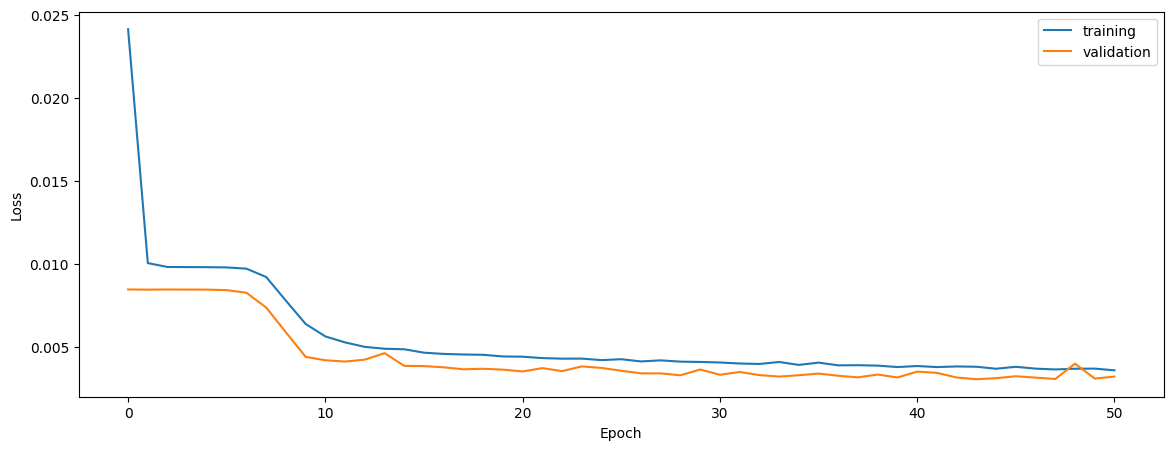

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7909355466955899
0.7980154503388309
0.7379983491474766


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.7909355466955899
0.7980154503388309
0.7379983491474766


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.7986266627810095
0.8047964027159568
0.7556801713082009


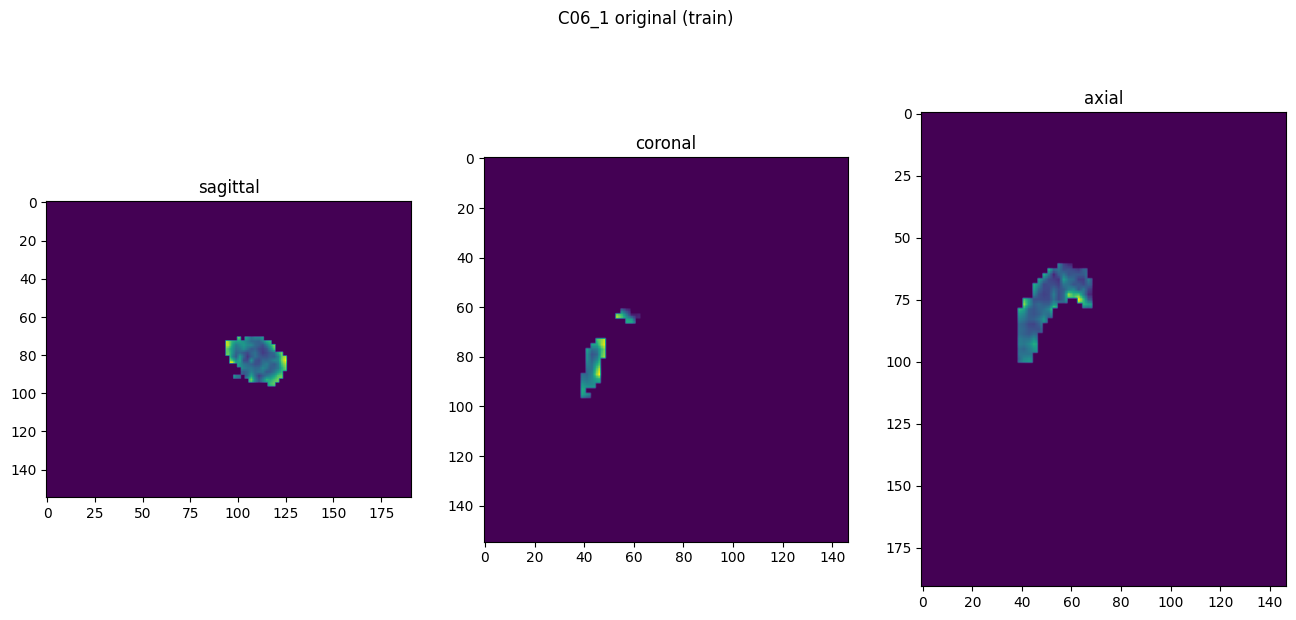

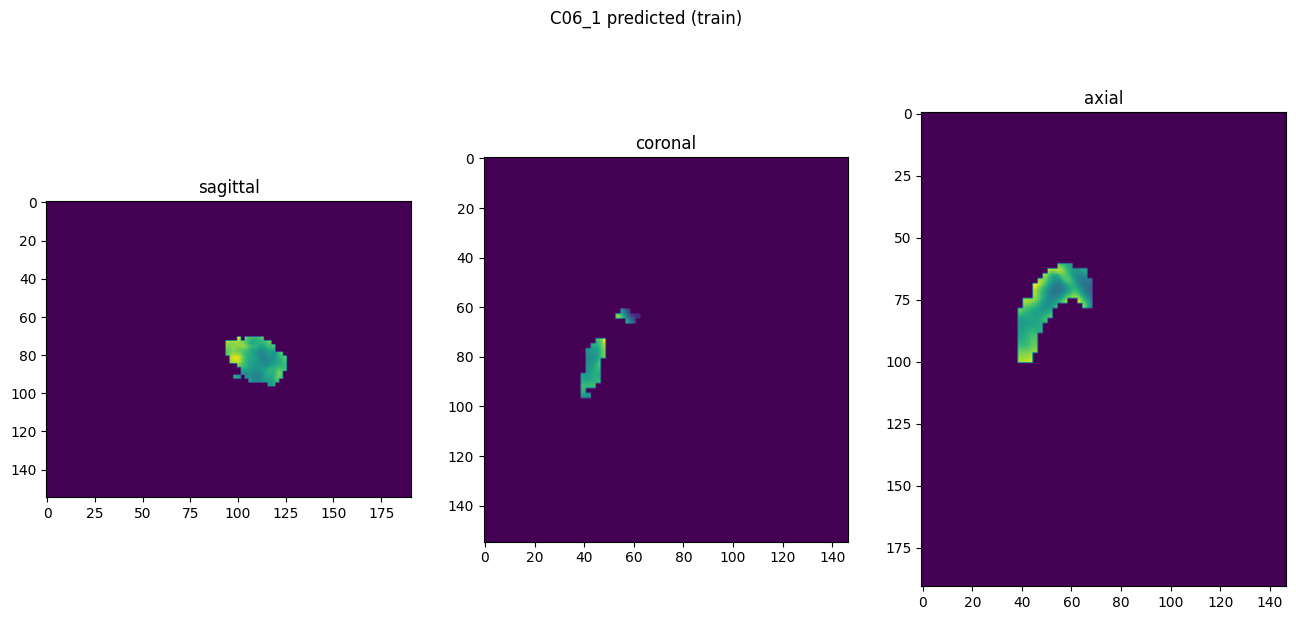

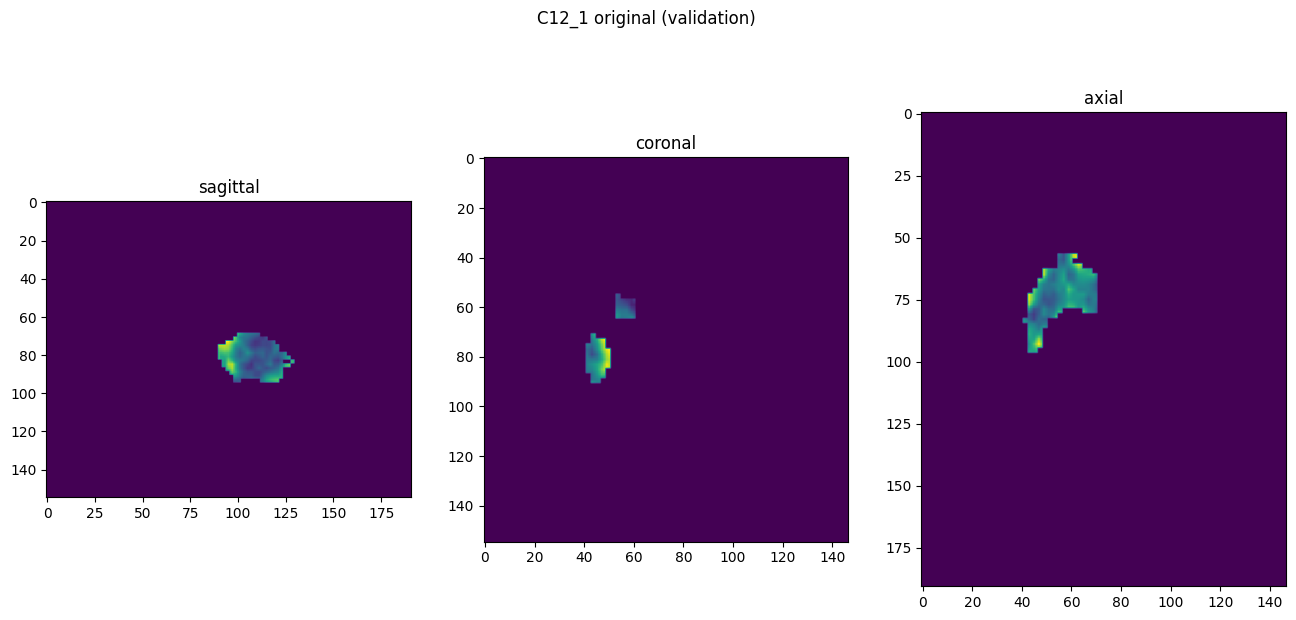

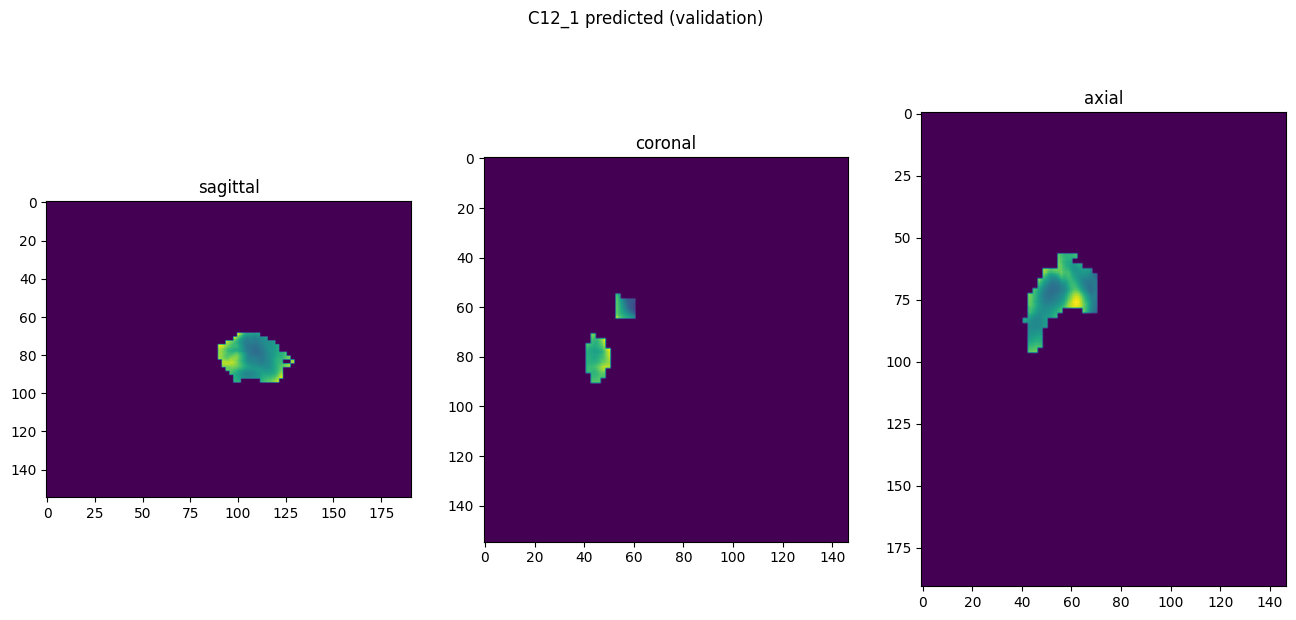

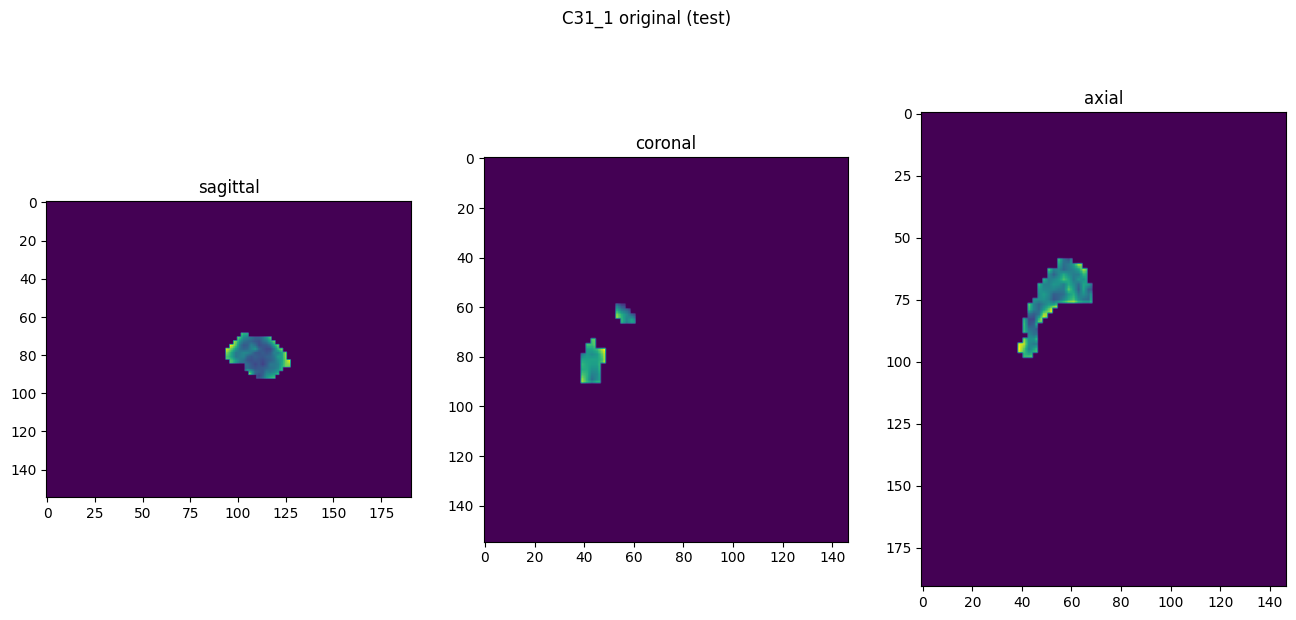

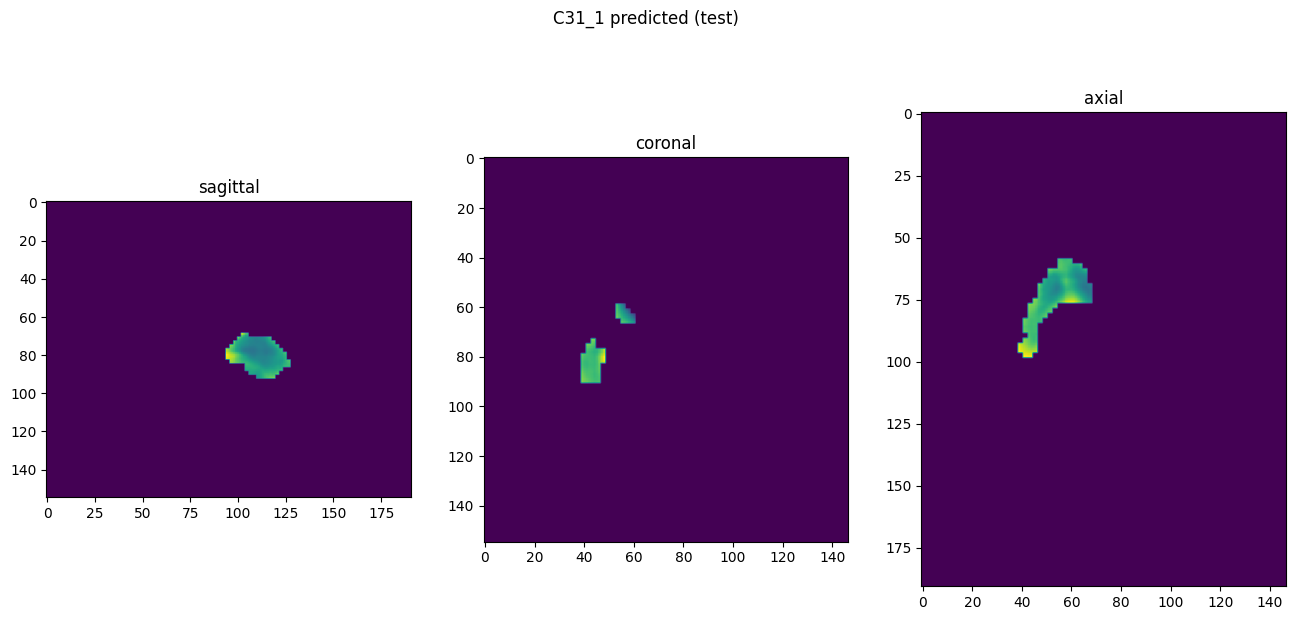

In [10]:
showResults(model, gen, threshold=None, background=False)